In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from social_dilemmas.envs.cleanup import CleanupEnv

In [6]:
env = CleanupEnv(
    num_agents=5,
    return_agent_actions=False)

In [10]:
env.observation_space["curr_obs"].dtype

dtype('uint8')

In [40]:
env.agents

{'agent-0': <social_dilemmas.envs.agent.CleanupAgent at 0x7f91d17ad040>,
 'agent-1': <social_dilemmas.envs.agent.CleanupAgent at 0x7f91d17ada60>,
 'agent-2': <social_dilemmas.envs.agent.CleanupAgent at 0x7f91d174e700>,
 'agent-3': <social_dilemmas.envs.agent.CleanupAgent at 0x7f91d174ed30>,
 'agent-4': <social_dilemmas.envs.agent.CleanupAgent at 0x7f91d174eb20>}

In [41]:
env.agents["agent-0"].action_map(0)

'MOVE_LEFT'

In [12]:
obs = env.reset()
# print(list(observations.keys()))
# env.observation_space, env.action_space
action = {"agent-{}".format(rank): 7 for rank in range(5)}
next_obs, reward, done, info = env.step(action)

In [13]:
obs

{'agent-0': {'curr_obs': array([[[ 99, 156, 194],
          [113,  75,  24],
          [ 99, 156, 194],
          [ 99, 156, 194],
          [113,  75,  24],
          [ 99, 156, 194],
          [113,  75,  24],
          [113,  75,  24],
          [113,  75,  24],
          [ 99, 156, 194],
          [113,  75,  24],
          [180, 180, 180],
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],
  
         [[ 99, 156, 194],
          [113,  75,  24],
          [ 99, 156, 194],
          [ 99, 156, 194],
          [113,  75,  24],
          [ 99, 156, 194],
          [113,  75,  24],
          [113,  75,  24],
          [113,  75,  24],
          [ 99, 156, 194],
          [113,  75,  24],
          [180, 180, 180],
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],
  
         [[ 99, 156, 194],
          [113,  75,  24],
          [ 99, 156, 194],
          [ 99, 156, 194],
          [113,  75,  24],
          [ 99, 156, 194

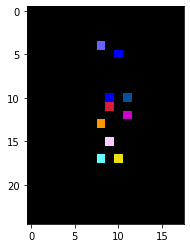

In [20]:
env.render()

In [44]:
reward

{'agent-0': -101, 'agent-1': -1, 'agent-2': -51, 'agent-3': -1, 'agent-4': -51}

In [54]:
list(obs.values())[0]["curr_obs"].shape

(15, 15, 3)

In [ ]:
# obs -> Bs x Ag(gumus) x H, W, C
#        R x E x A x H x W x C
# act -> Bs x Ag

In [4]:
import gym
import torch
import numpy as np
from collections import namedtuple

from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env.vec_transpose import VecTransposeImage

from modular_baselines.buffers.buffer import RolloutBuffer
from modular_baselines.collectors.collector import OnPolicyCollector
from modular_baselines.algorithms.a2c import A2C
from modular_baselines.runners.multi_seed import MultiSeedRunner
from modular_baselines.loggers.basic import(InitLogCallback,
                                            LogRolloutCallback,
                                            LogWeightCallback,
                                            LogGradCallback,
                                            LogHyperparameters)

from social_dilemmas.envs.cleanup import CleanupEnv

In [18]:
dir(env)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'action_space',
 'agent_pos',
 'agents',
 'all_actions',
 'apple_points',
 'ascii_to_numpy',
 'base_map',
 'beam_pos',
 'build_walls',
 'check_agent_map',
 'color_map',
 'color_view',
 'compute_permitted_area',
 'compute_probabilities',
 'current_apple_spawn_prob',
 'current_waste_spawn_prob',
 'custom_action',
 'custom_map_update',
 'custom_reset',
 'find_visible_agents',
 'full_map_to_colors',
 'get_environment_callbacks',
 'get_map_with_agents',
 'map_padding',
 'map_to_colors',
 'num_agents',
 'observation_space',
 'pos_dict',
 'potential_waste_area',
 'render',
 'reset',
 'reset_map',
 'return_agent_actions',
 'river

In [45]:
from typing import Optional, Tuple, Dict

class CleanupAction(gym.ActionWrapper):

    def __init__(self, env, n_agent):
        super().__init__(env)
        self.n_agent = len(self.env.agents)
        self.action_space = gym.spaces.MultiDiscrete(self.n_agent)
        
    def action(action):
        assert len(action.shape) == 1
        actions = {name: action[index] for name, index in enumerate()}
        return actions
    

class CleanupObservation(gym.ObservationWrapper):
    
    def __init__(self, env):
        super().__init__(env)
        self.n_agent = len(self.env.agents)
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self.n_agent, *env.observation_space["curr_obs"].shape),
            dtype=env.observation_space["curr_obs"].dtype)
        
    def observation(self, dict_obs):
        return np.stack([obs["curr_obs"] for obs in dict_obs.values()])
    
    
class CleanupWrapper(gym.Env):
    
    def __init__(self, env):
        self.env = env
        self.n_agent = len(self.env.agents)
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self.n_agent, *env.observation_space["curr_obs"].shape),
            dtype=env.observation_space["curr_obs"].dtype)
        self.action_space = gym.spaces.MultiDiscrete(self.n_agent)
        
    def _action(self, action):
        assert len(action.shape) == 1
        actions = {name: action[index] for index, name in enumerate(self.env.agents.keys())}
        return actions
    
    def _observation(self, dict_obs):
        return np.stack([obs["curr_obs"] for obs in dict_obs.values()])
    
    def _reward(self, reward):
        return np.array(list(reward.values()), dtype=np.float64)
    
    def step(self, action):
        env_action = self._action(action)
        raw_obs, reward, done, info = self.env.step(env_action)
        all_done = done.pop("__all__")
        info["done/remaining"] = done
        return self._observation(raw_obs), self._reward(reward), all_done, info
    
    def reset(self):
        return self._observation(self.env.reset())
        

In [46]:
wrapped_env = CleanupWrapper(env)
wrapped_env.reset().shape
obs, reward, done, info = wrapped_env.step(np.ones(5))

In [49]:
class DencentralizedRolloutBuffer(RolloutBuffer):
    
    def reset(self) -> None:
        self.observations = np.zeros((self.buffer_size, self.n_envs) + self.obs_shape, dtype=np.float32)
        self.actions = np.zeros((self.buffer_size, self.n_envs, self.action_dim), dtype=np.float32)
        self.rewards = np.zeros((self.buffer_size, self.n_envs, self.action_dim), dtype=np.float32)
        self.returns = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.episode_starts = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.values = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.log_probs = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.advantages = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.generator_ready = False
        super(RolloutBuffer, self).reset()
        
    def compute_returns_and_advantage(self, last_values: th.Tensor, dones: np.ndarray) -> None:
        raise NotImplementedError

{'done/__all__': False}

In [ ]:
class Policy(torch.nn.Module):

    def __init__(self,
                 observation_space: gym.spaces.Box,
                 action_space: gym.spaces.Discrete,
                 hidden_size: int = 128,
                 lr=1e-3,
                 rms_prob_eps=1e-5,
                 ortho_init=True):
        super().__init__()
        self.observation_space = observation_space
        self.action_space = action_space
        self.hidden_size = hidden_size
        self.ortho_init = ortho_init

        if not isinstance(observation_space, gym.spaces.Box):
            raise ValueError("Unsupported observation space {}".format(
                observation_space))
        if not isinstance(action_space, gym.spaces.Discrete):
            raise ValueError("Unsupported action space {}".format(
                observation_space))

        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(observation_space.shape[0], 32,
                            kernel_size=8, stride=4, padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(7 * 7 * 64, 512),
            torch.nn.ReLU()
        )
        self.action_layers = torch.nn.Sequential(
            torch.nn.Linear(512, action_space.n)
        )
        self.value_layers = torch.nn.Sequential(
            torch.nn.Linear(512, 1)
        )

        if self.ortho_init:
            # Taken from SB3 ActorCriticPolicy class
            module_gains = {
                self.cnn: np.sqrt(2),
                self.action_layers: 0.01,
                self.value_layers: 1,
            }
            for module, gain in module_gains.items():
                module.apply(
                    partial(ActorCriticCnnPolicy.init_weights, gain=gain))

        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=lr,
                                          eps=rms_prob_eps)

    def _forward(self, tensor):
        processed_tensor = self._preprocess(tensor)
        features = self.cnn(processed_tensor)

        act_logit = self.action_layers(features)
        values = self.value_layers(features)
        return act_logit, values

    def _preprocess(self, tensor):
        return tensor.float() / 255

    def forward(self, tensor):
        act_logit, values = self._forward(tensor)

        dist = torch.distributions.categorical.Categorical(logits=act_logit)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, values, log_prob

    def evaluate_actions(self, observation, action):
        act_logit, values = self._forward(observation)
        dist = torch.distributions.categorical.Categorical(logits=act_logit)
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return values, log_prob, entropy

In [ ]:
args = dict(
    rollout_len=2048,
    n_envs=5,
    device="cpu",
    gamma=0.99
)
args = namedtuple("Args", " ".join(args.keys())(*args.values())

In [ ]:
buffer = DencentralizedRolloutBuffer(
    buffer_size=args.rollout_len,
    observation_space=env.observation_space,
    action_space=env.action_space,
    device=args.device,
    gae_lambda=1.0,
    gamma=args.gamma,
    n_envs=args.n_envs
)

# sample -> 

policy = Policy(vecenv.observation_space,
                vecenv.action_space,
                hidden_size=args.hiddensize,
                lr=args.lr,
                rms_prob_eps=args.rms_prop_eps,
                ortho_init=args.ortho_init)
vecenv = make_env(n_envs=args.n_envs,
                  seed=seed)
collector = OnPolicyCollector(env=vecenv,
                              buffer=buffer,
                              policy=policy,
                              device=args.device)